# Plots

Below we plot many of the Softjax functions for different modes and softnesses to give an idea of how they look like.
All functions are designed to be soft when used on inputs in an interval [0,1] when setting default softness of 1.0. 
When inputs in other ranges are used, softness can be scaled accrdingly, e.g. on inputs distributed in the inteval [0, 100] a softness of 100.0 should result in a soft behavior.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import softjax as sj
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D


jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_matmul_precision", "high")
jax.config.update("jax_platforms", "cpu")


In [2]:
linewidth = 1.0
SMALL_SIZE = 6
MEDIUM_SIZE = 6
BIGGER_SIZE = 6

plt.rcParams["figure.dpi"] = 200
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


def plot(
    fn,
    modes,
    title="",
    softnesses=[3.0, 1.0, 0.3],
    xs=jnp.linspace(-2, 2, 1001),
    **kwargs,
):
    xs = jnp.array(xs)

    colormap = LinearSegmentedColormap.from_list(
        "blue_red", ["dodgerblue", "gold", "lightcoral"]
    )
    # colormap = plt.get_cmap("coolwarm")
    # colormap = plt.get_cmap("Blues")
    colors = colormap(jnp.array(softnesses) / max(softnesses))

    # Create plotting canvas
    fig, axes = plt.subplots(
        2,
        len(modes),
        figsize=(3 * len(modes), 3.5),
        sharex=True,
        sharey="row",
        squeeze=False,
    )

    for col_idx, mode in enumerate(modes):
        ax_f = axes[0][col_idx]
        ax_g = axes[1][col_idx]

        if softnesses:
            for softness, color in zip(softnesses, colors):
                _softness = softness
                ys, grad_vals = jax.vmap(
                    lambda x: jax.value_and_grad(fn)(
                        x, mode=mode, softness=_softness, **kwargs
                    )
                )(xs)
                ax_f.plot(xs, ys, linewidth=linewidth, color=color)
                ax_g.plot(
                    xs,
                    np.array(grad_vals),
                    linewidth=linewidth,
                    color=color,
                )

        ys, grad_vals = jax.vmap(
            lambda x: jax.value_and_grad(fn)(x, mode="hard", softness=None)
        )(xs)
        ax_f.plot(xs, ys, linewidth=linewidth, linestyle="--", color="black")
        ax_g.plot(
            xs,
            grad_vals,
            linewidth=linewidth,
            linestyle="--",
            color="black",
        )

        # ax_f.set_title(f"[{mode}]")
        ax_f.text(
            0.01, 0.99, f"[{mode}]", ha="left", va="top", transform=ax_f.transAxes
        )
        # ax_g.set_title(f"[{mode}]")

        for ax in (ax_f, ax_g):
            # ax.grid(True, linestyle="--", alpha=0.6)
            ax.axhline(0, color="black", linewidth=0.5, alpha=0.7)
            ax.axvline(0, color="black", linewidth=0.5, alpha=0.7)
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)
            ax.set_xticks([-1.0, 0.0, 1.0])
            ax.margins(x=0)

    # Label axes
    for ax in axes[-1]:
        ax.set_xlabel("x")  # fontsize=14)

    axes[0][0].set_ylabel("function")
    axes[1][0].set_ylabel("gradient")
    axes[0][0].set_yticks([min(min(ys), 0), max(ys)])

    # fig.suptitle(title) #fontsize=20)

    # Build a shared legend for softnesses
    handles = [
        Line2D([0], [0], color=color, lw=1, label=str(s))
        for s, color in zip(softnesses, colors)
    ]
    handles.append(Line2D([0], [0], color="black", lw=1, label=f"{fn.__name__}"))
    handles.reverse()
    fig.legend(
        handles=handles,
        title="softness",
        loc="upper right",
        bbox_to_anchor=(1.0, 0.98),
        ncol=min(len(softnesses) + 1, 6),
        frameon=False,
    )

    # Leave space for the legend and title
    fig.tight_layout(rect=(0, 0, 1, 0.9))
    plt.locator_params(axis="both", nbins=3)
    plt.show()

## Sigmoid-based

In [3]:
# sigmoid_modes = ["entropic", "euclidean", "pseudohuber", "cubic", "quintic"]
sigmoid_modes = ["entropic", "euclidean", "quintic"]

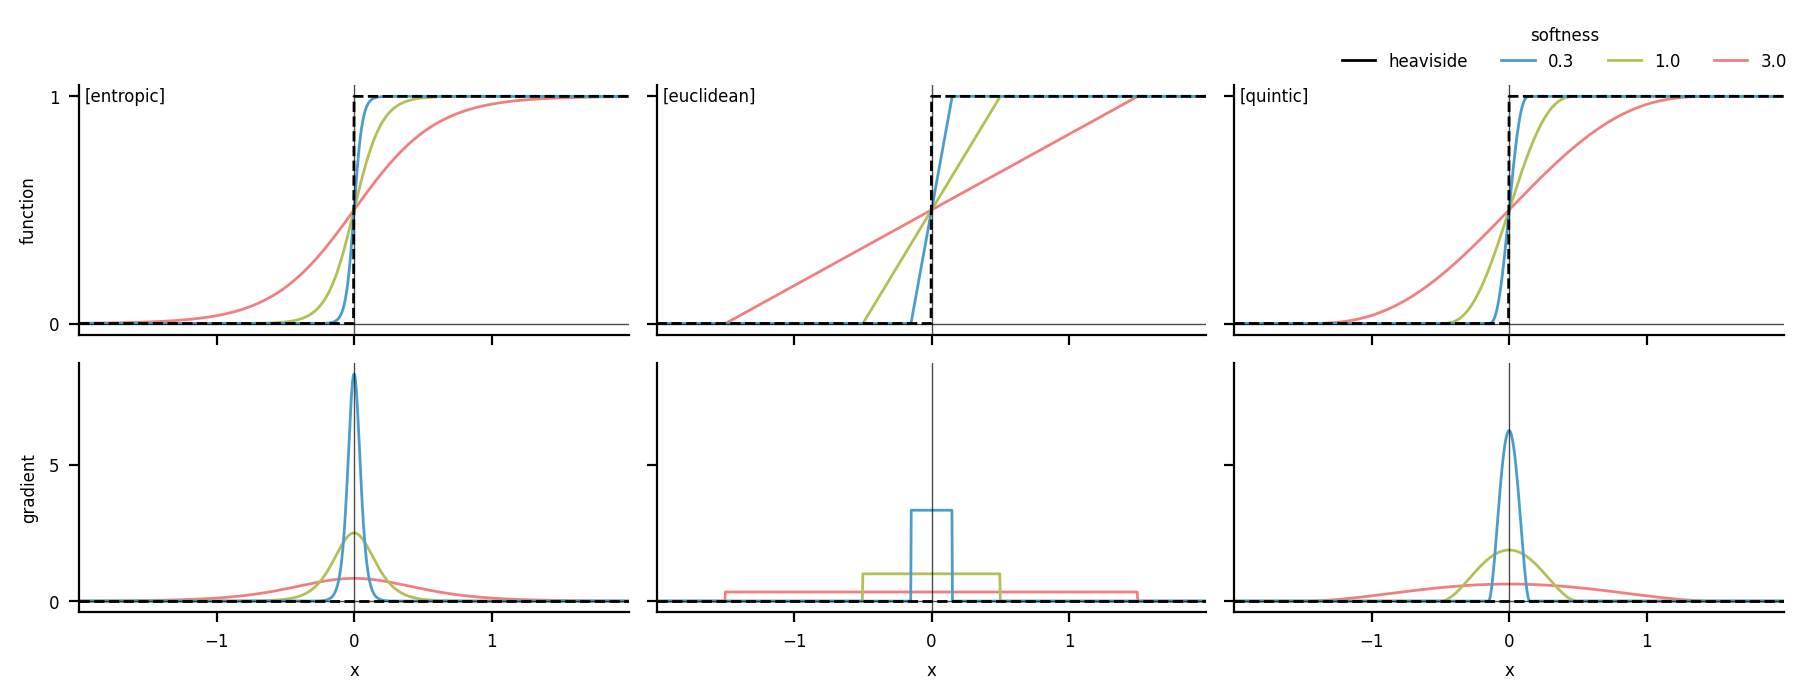

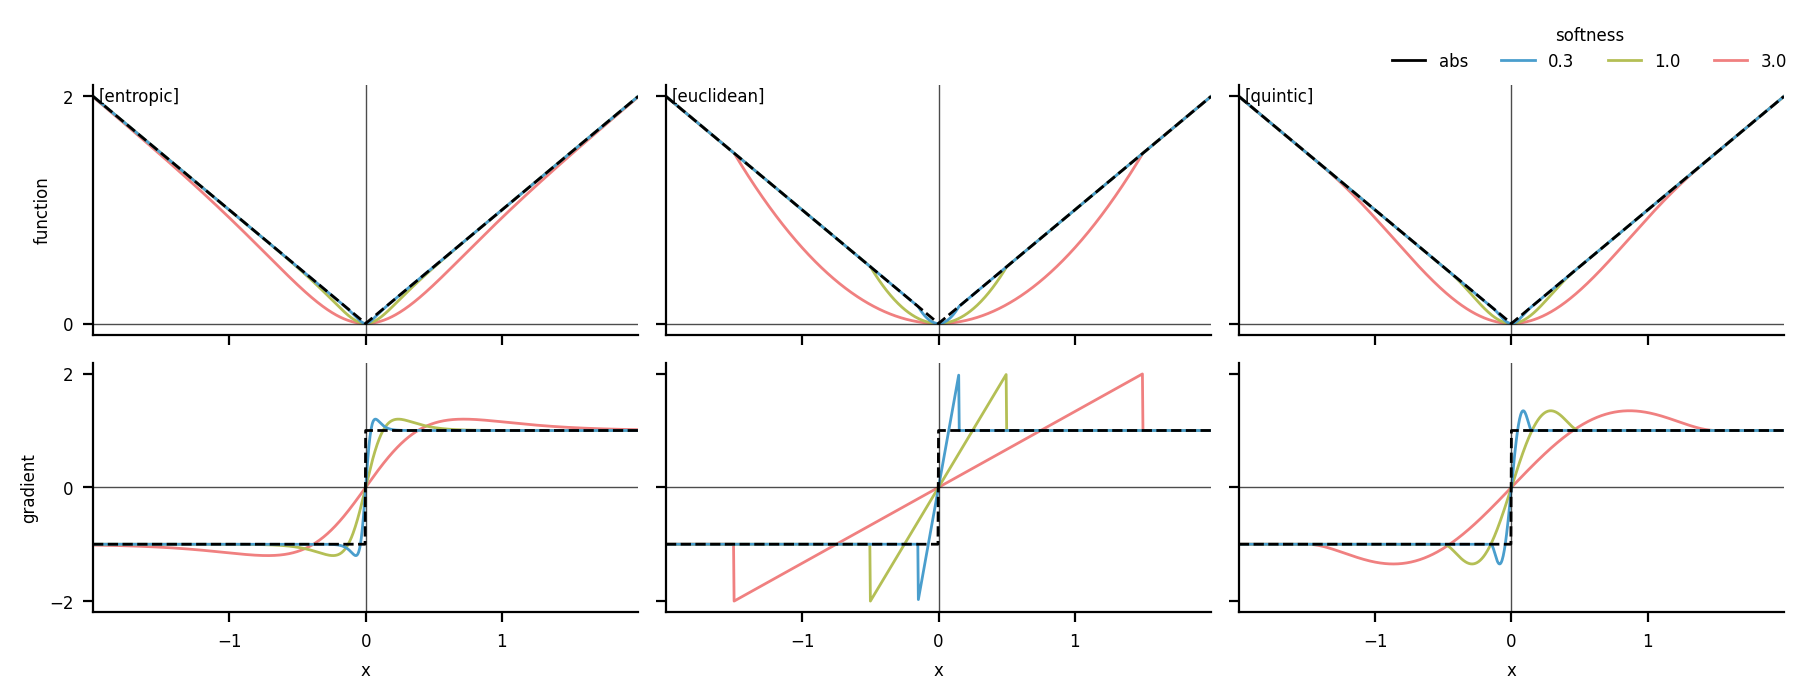

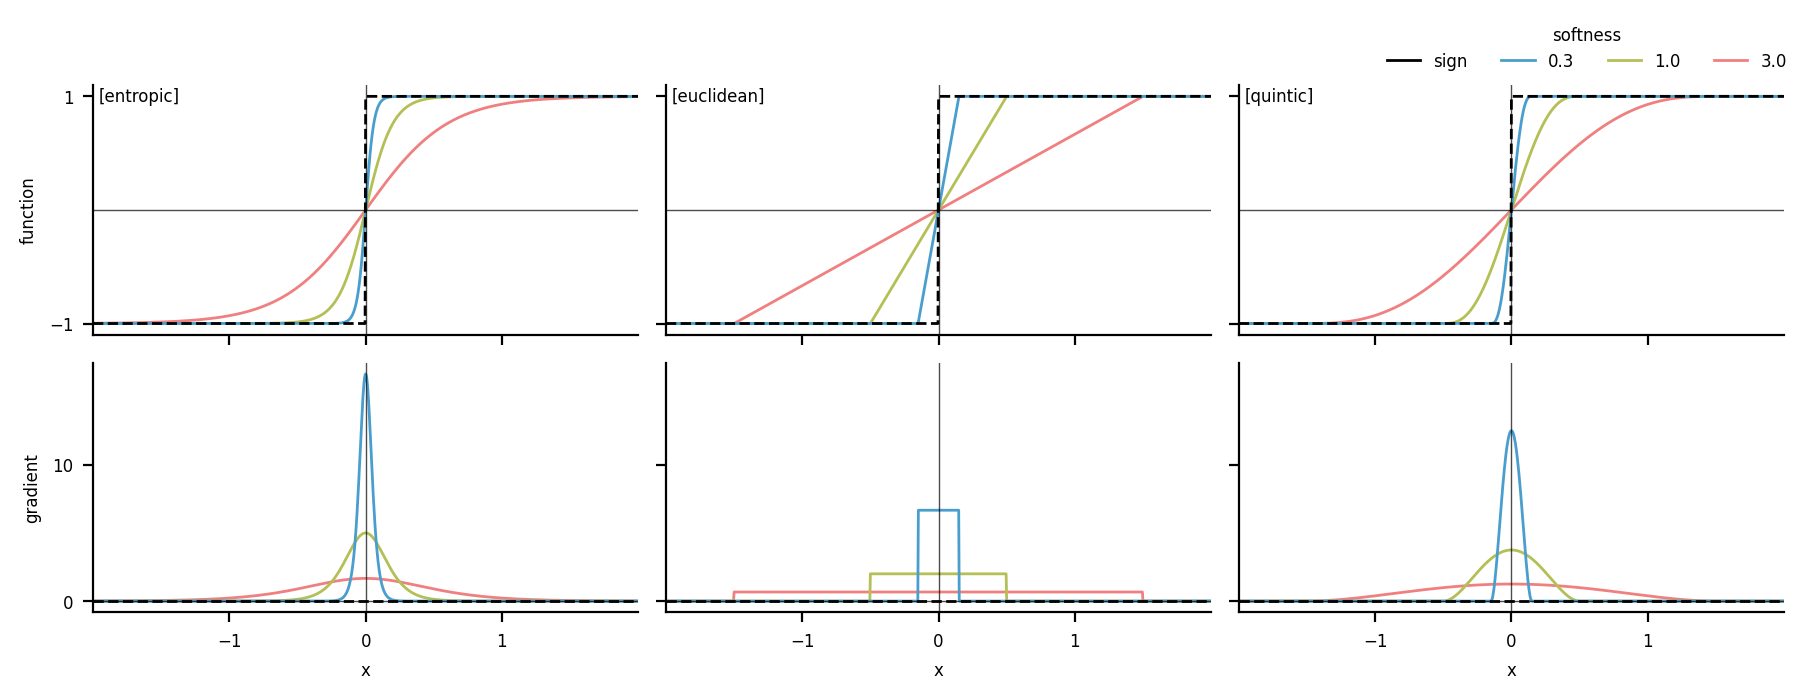

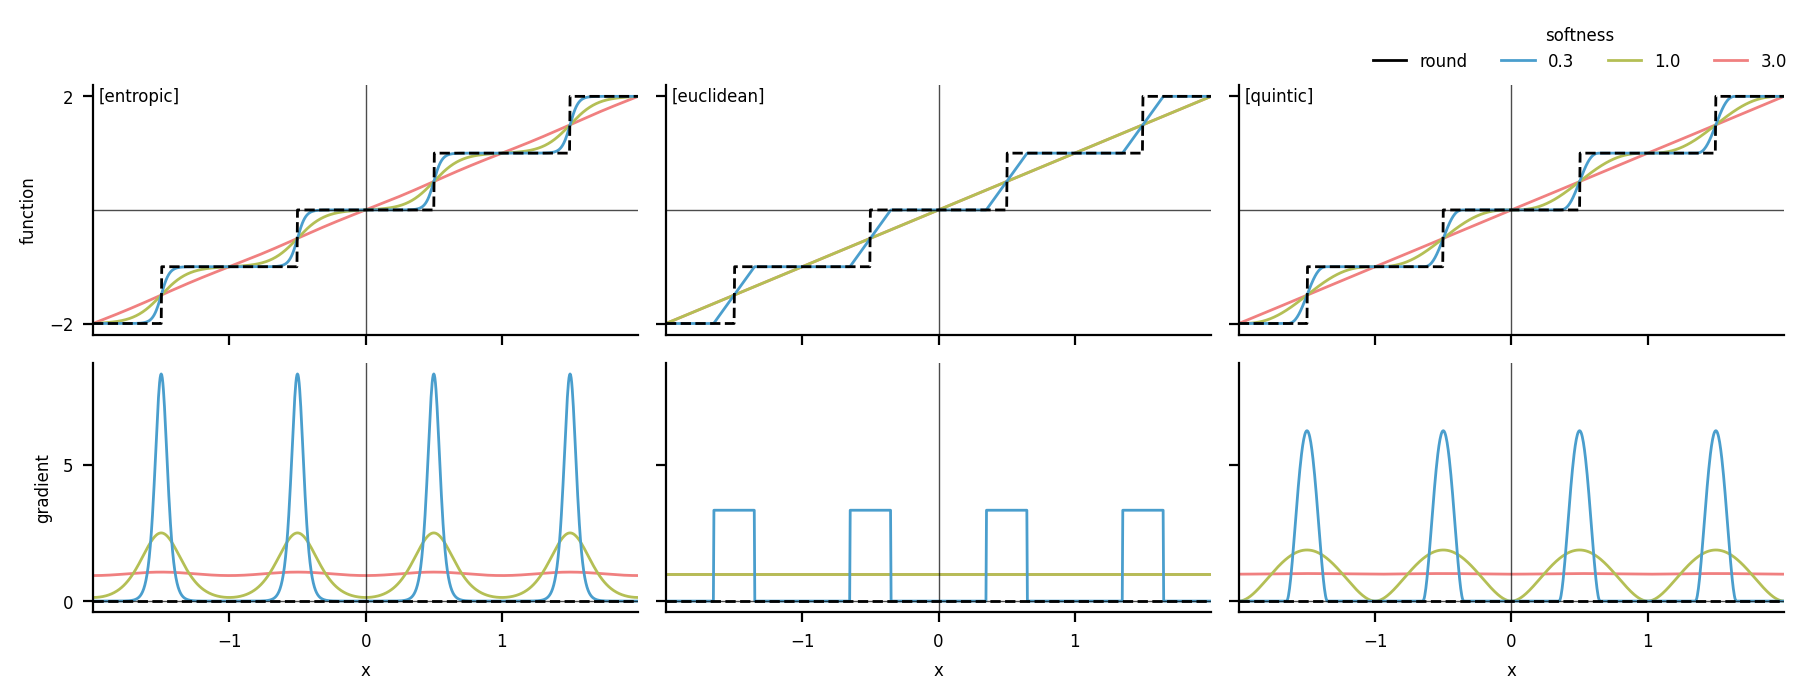

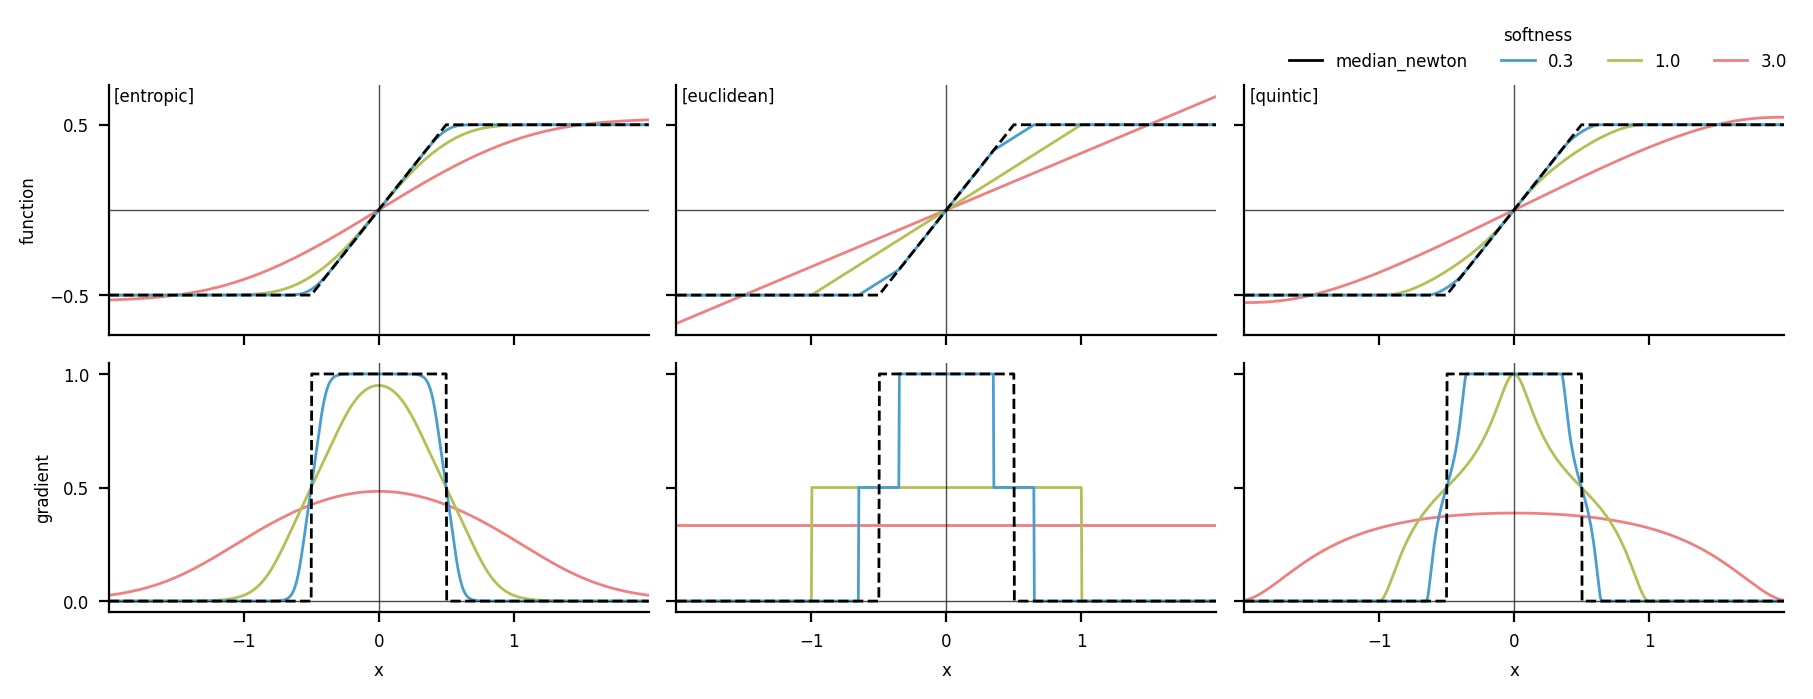

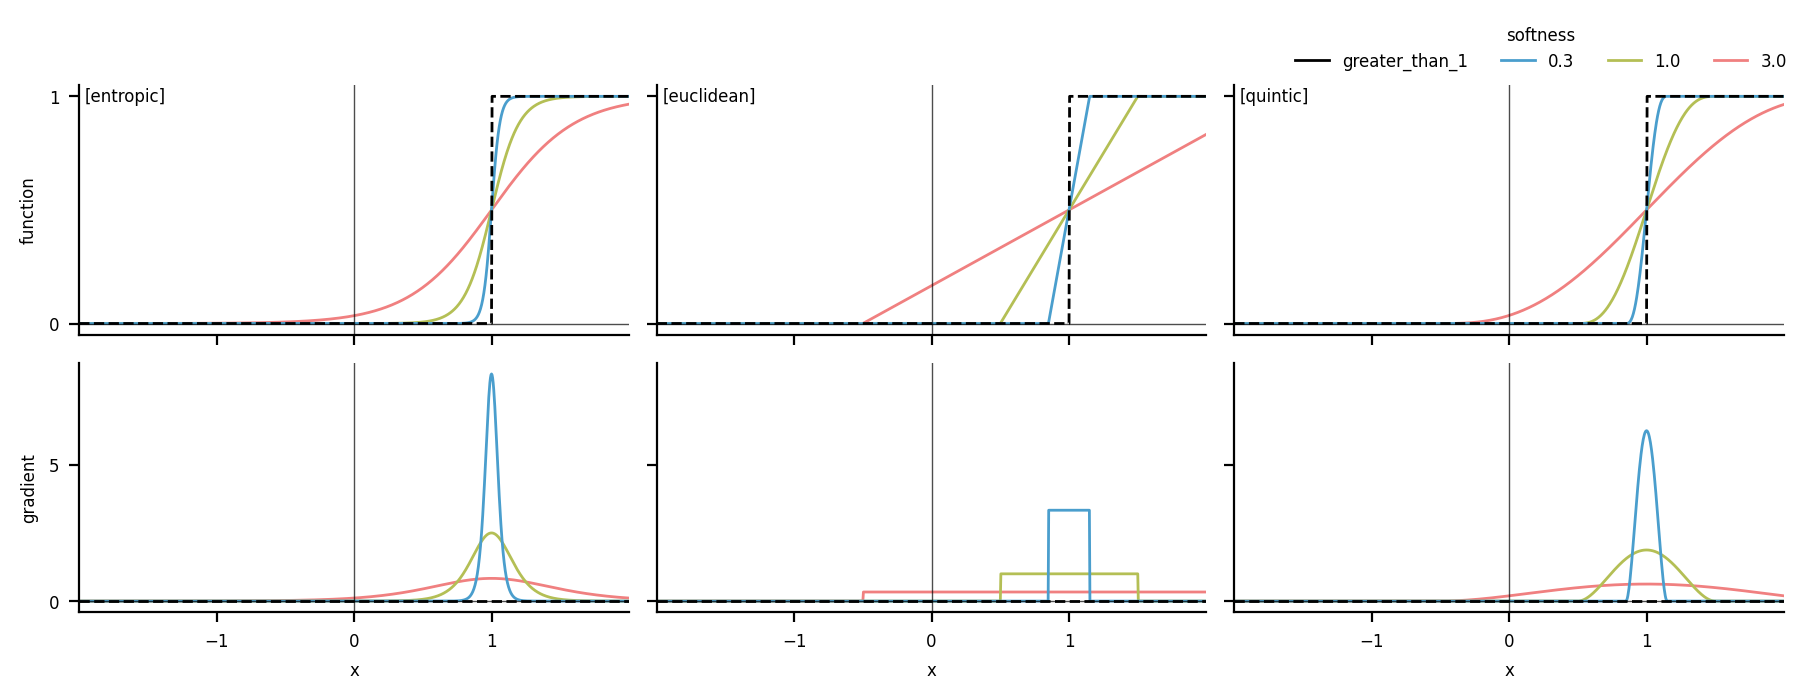

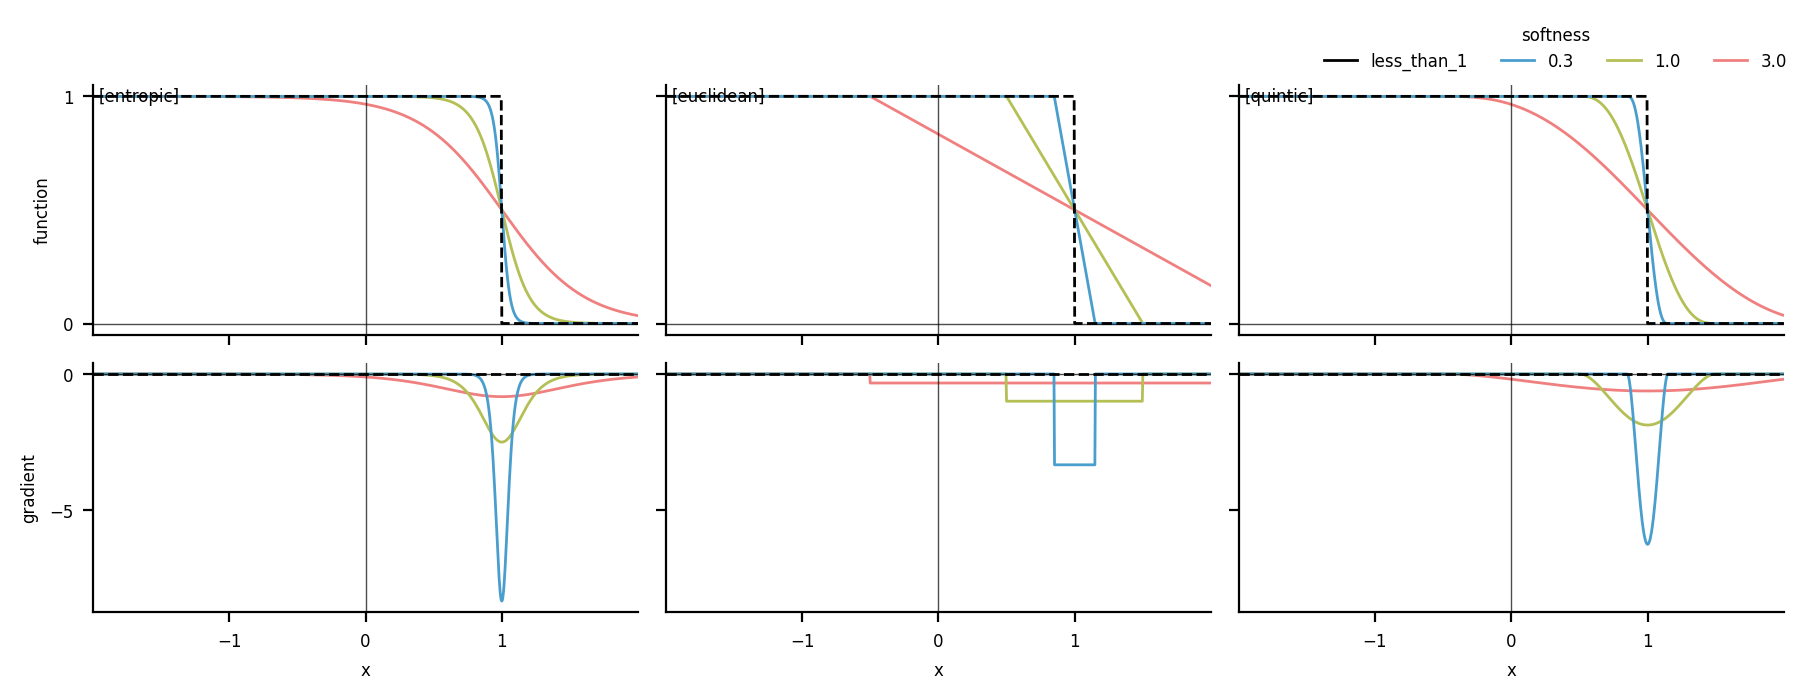

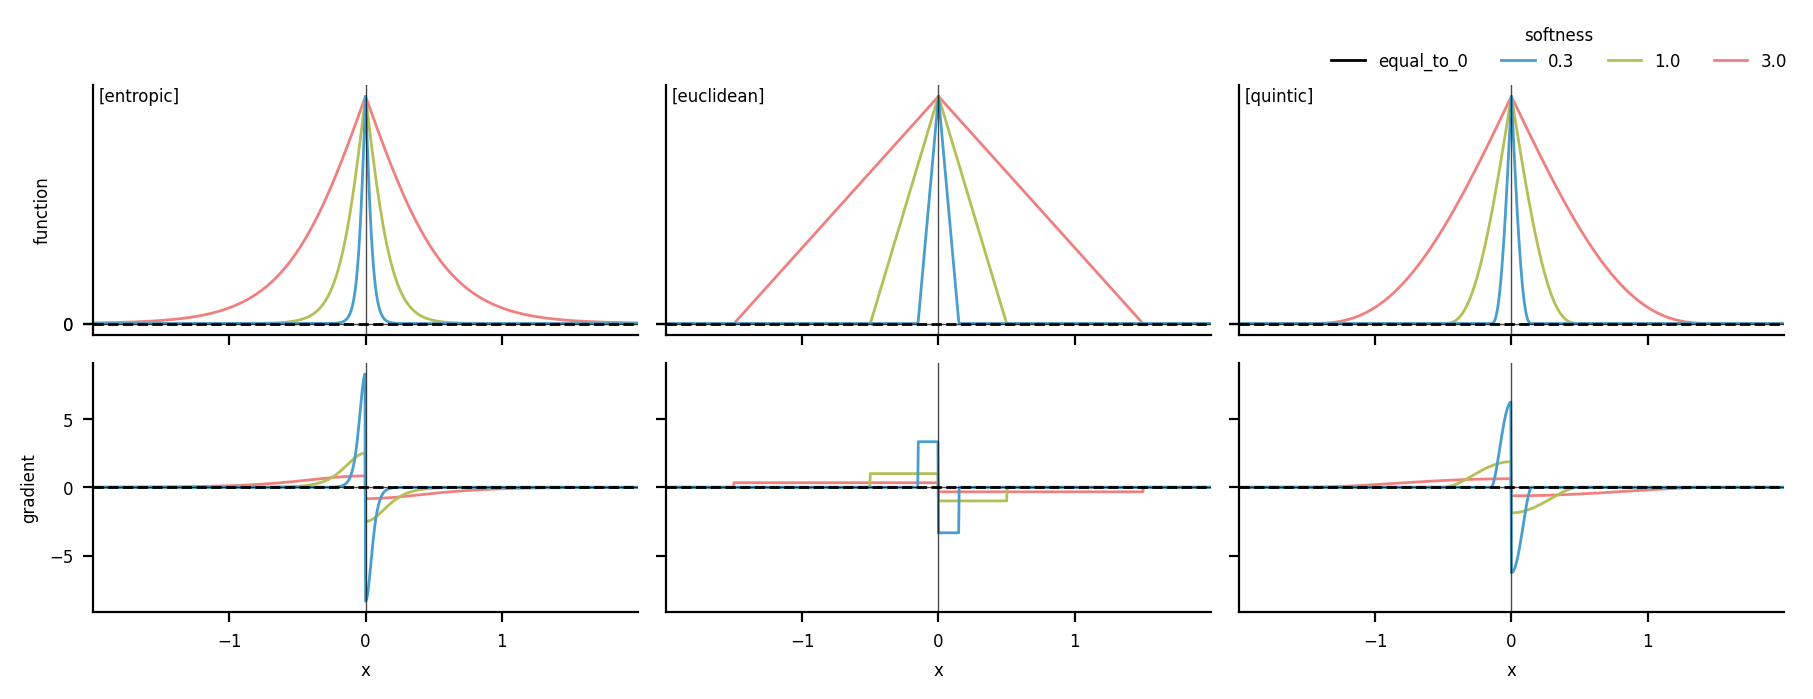

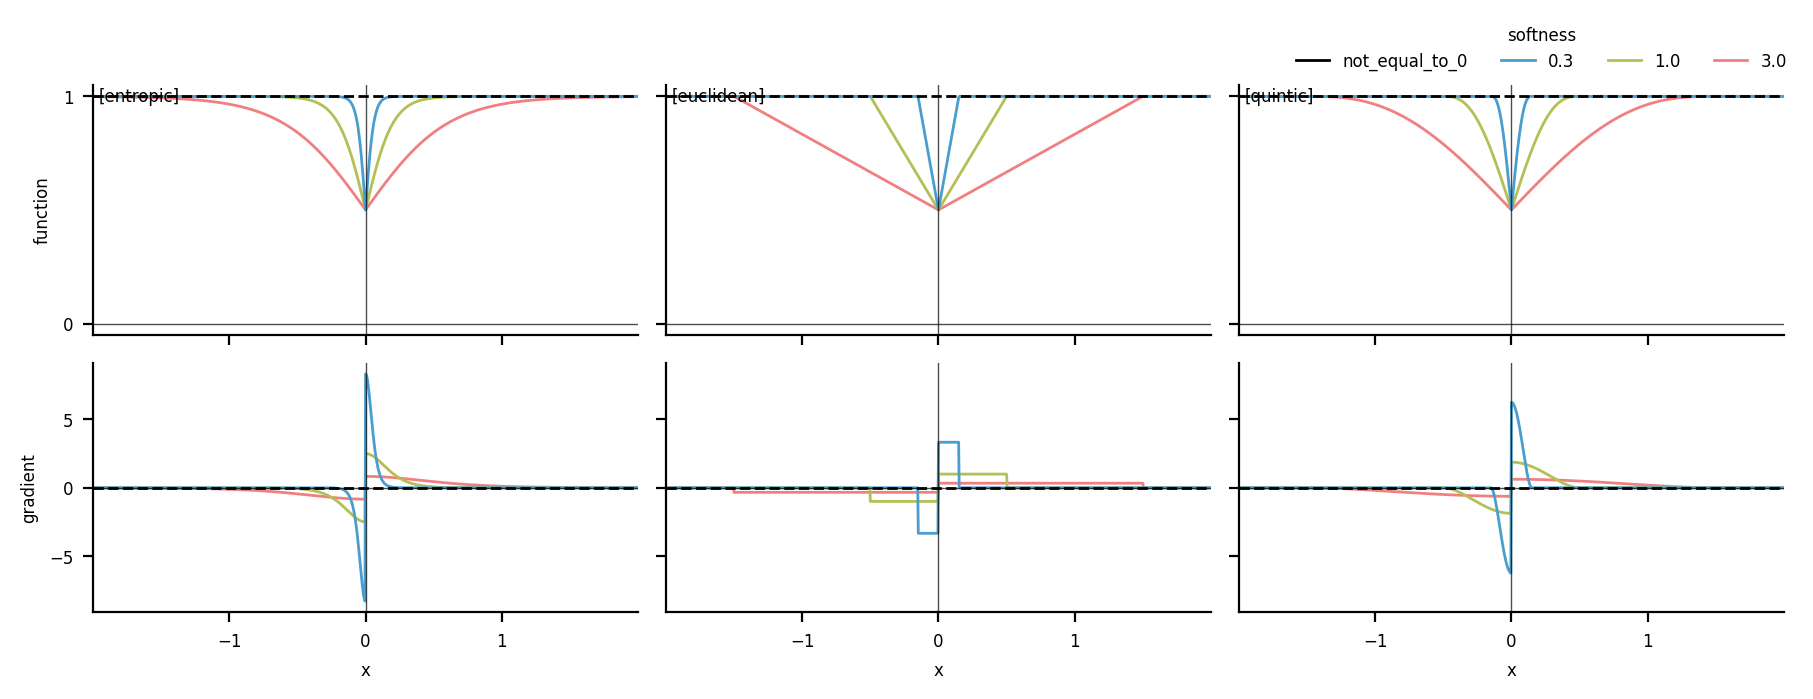

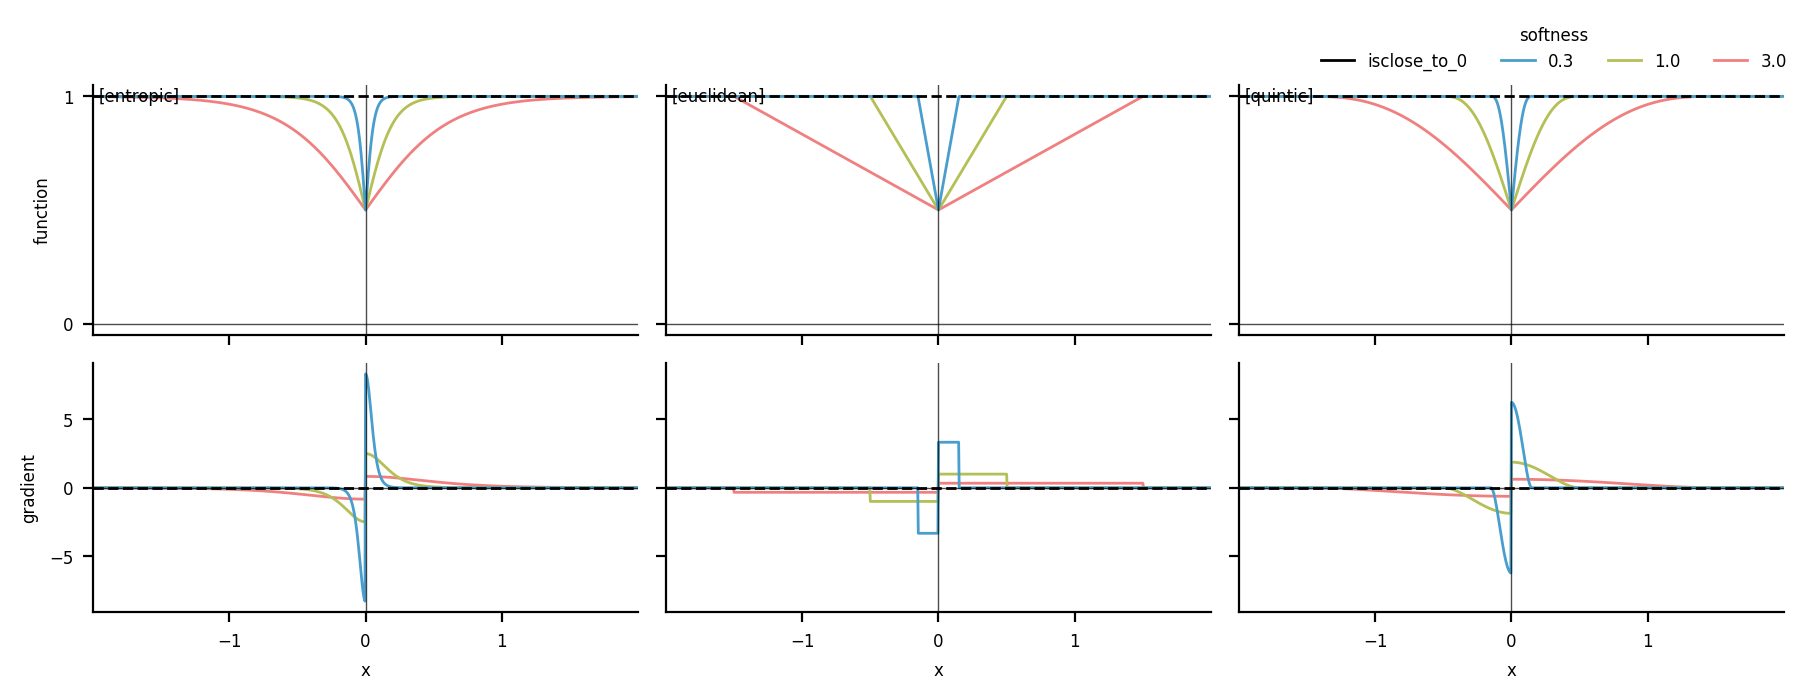

In [4]:
def median_newton(x, **kwargs):
    return sj.median_newton(jnp.array([x, -0.5, 0.5]), **kwargs)


def greater_than_1(x, **kwargs):
    return sj.greater(x, jnp.array(1.0), **kwargs)


def less_than_1(x, **kwargs):
    return sj.less(x, jnp.array(1.0), **kwargs)


def equal_to_0(x, **kwargs):
    return sj.equal(x, jnp.array(0.0), **kwargs)


def not_equal_to_0(x, **kwargs):
    return sj.not_equal(x, jnp.array(0.0), **kwargs)


def isclose_to_0(x, **kwargs):
    return sj.not_equal(x, jnp.array(0.0), **kwargs)


plot(sj.heaviside, modes=sigmoid_modes)
plot(sj.abs, modes=sigmoid_modes)
plot(sj.sign, modes=sigmoid_modes)
plot(sj.round, modes=sigmoid_modes)
plot(median_newton, modes=sigmoid_modes)
plot(greater_than_1, modes=sigmoid_modes)
plot(less_than_1, modes=sigmoid_modes)
plot(equal_to_0, modes=sigmoid_modes)
plot(not_equal_to_0, modes=sigmoid_modes)
plot(isclose_to_0, modes=sigmoid_modes)

## Softplus-based

In [5]:
softplus_modes = ["entropic", "euclidean", "quartic"]
softplus_modes_gated = [
    "gated_entropic",
    "gated_euclidean",
    "gated_cubic",
    "gated_quintic",
]

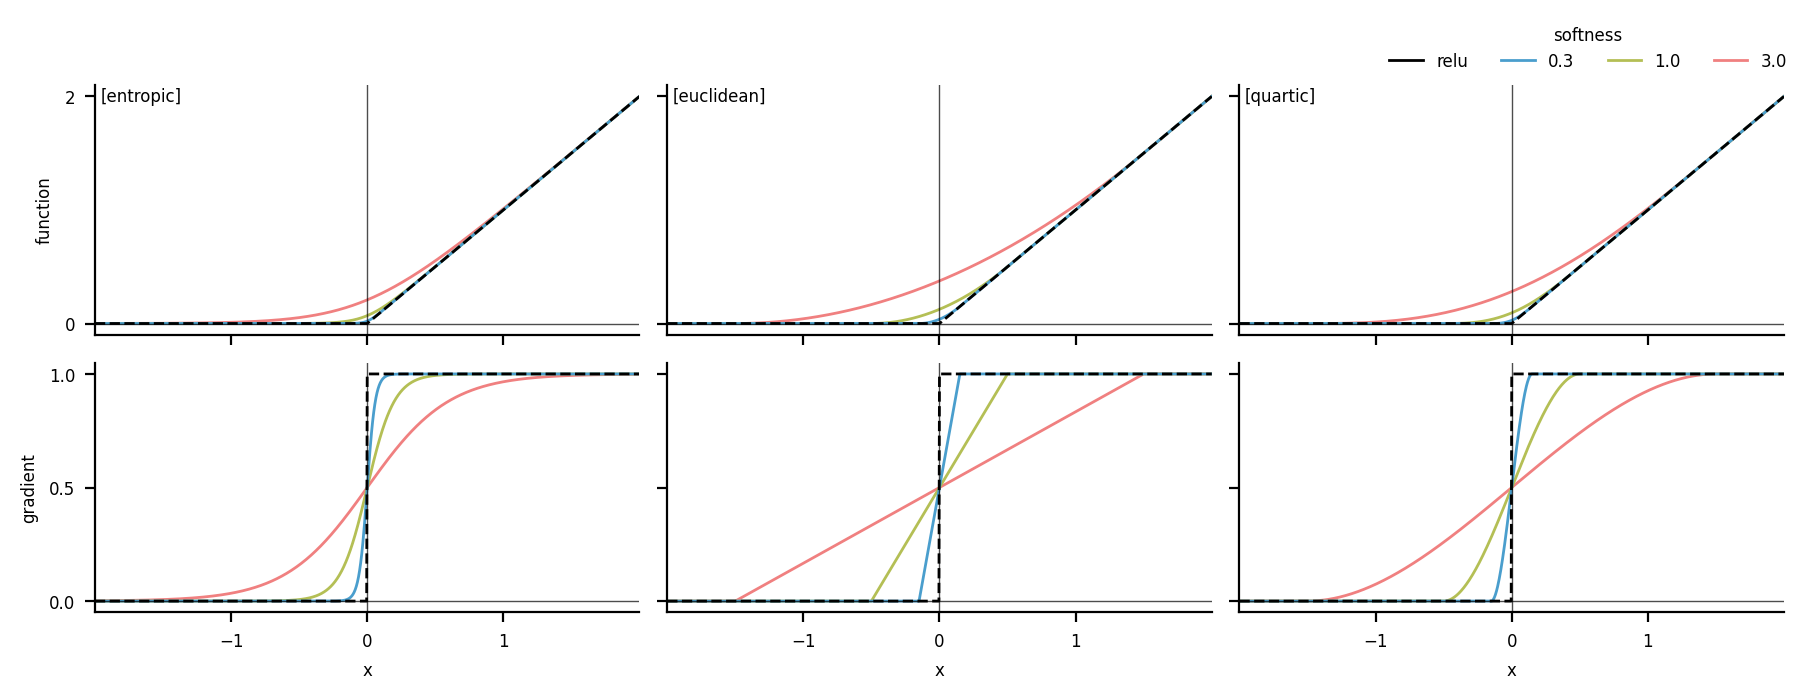

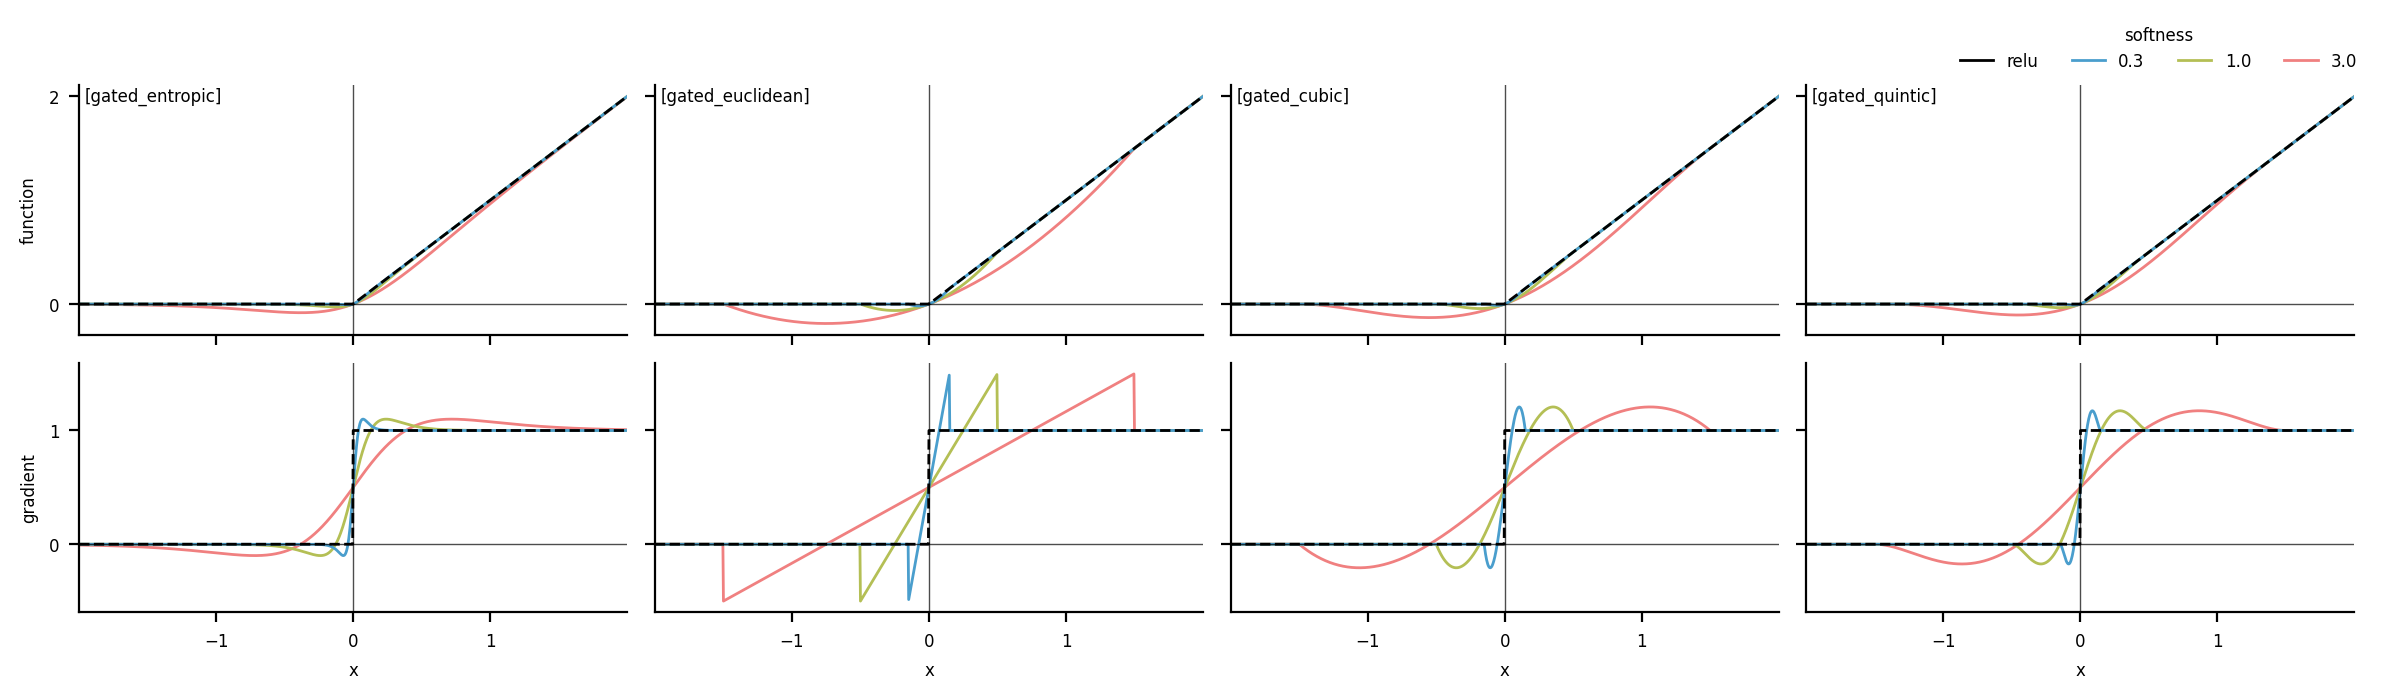

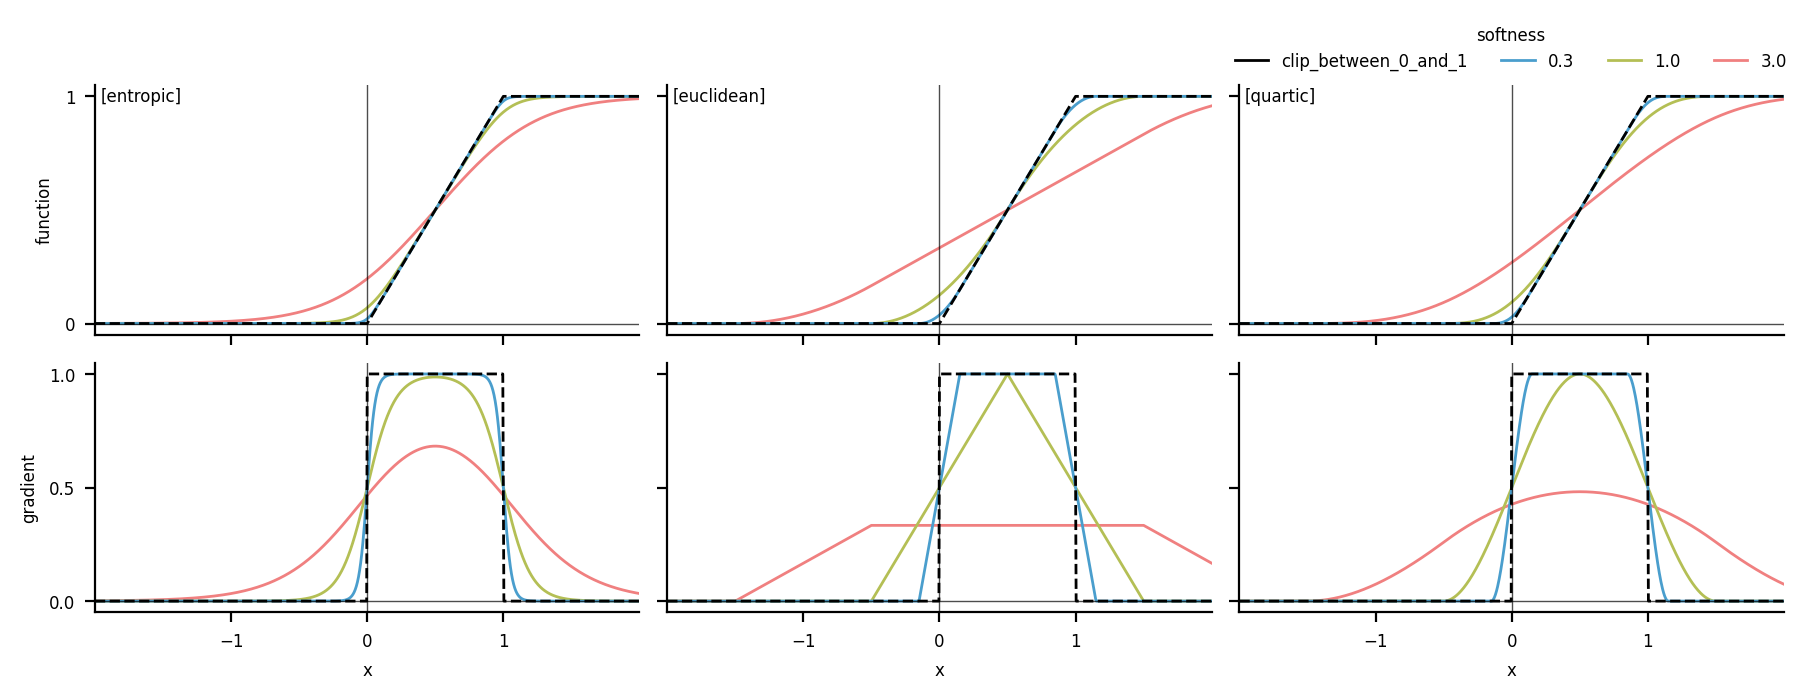

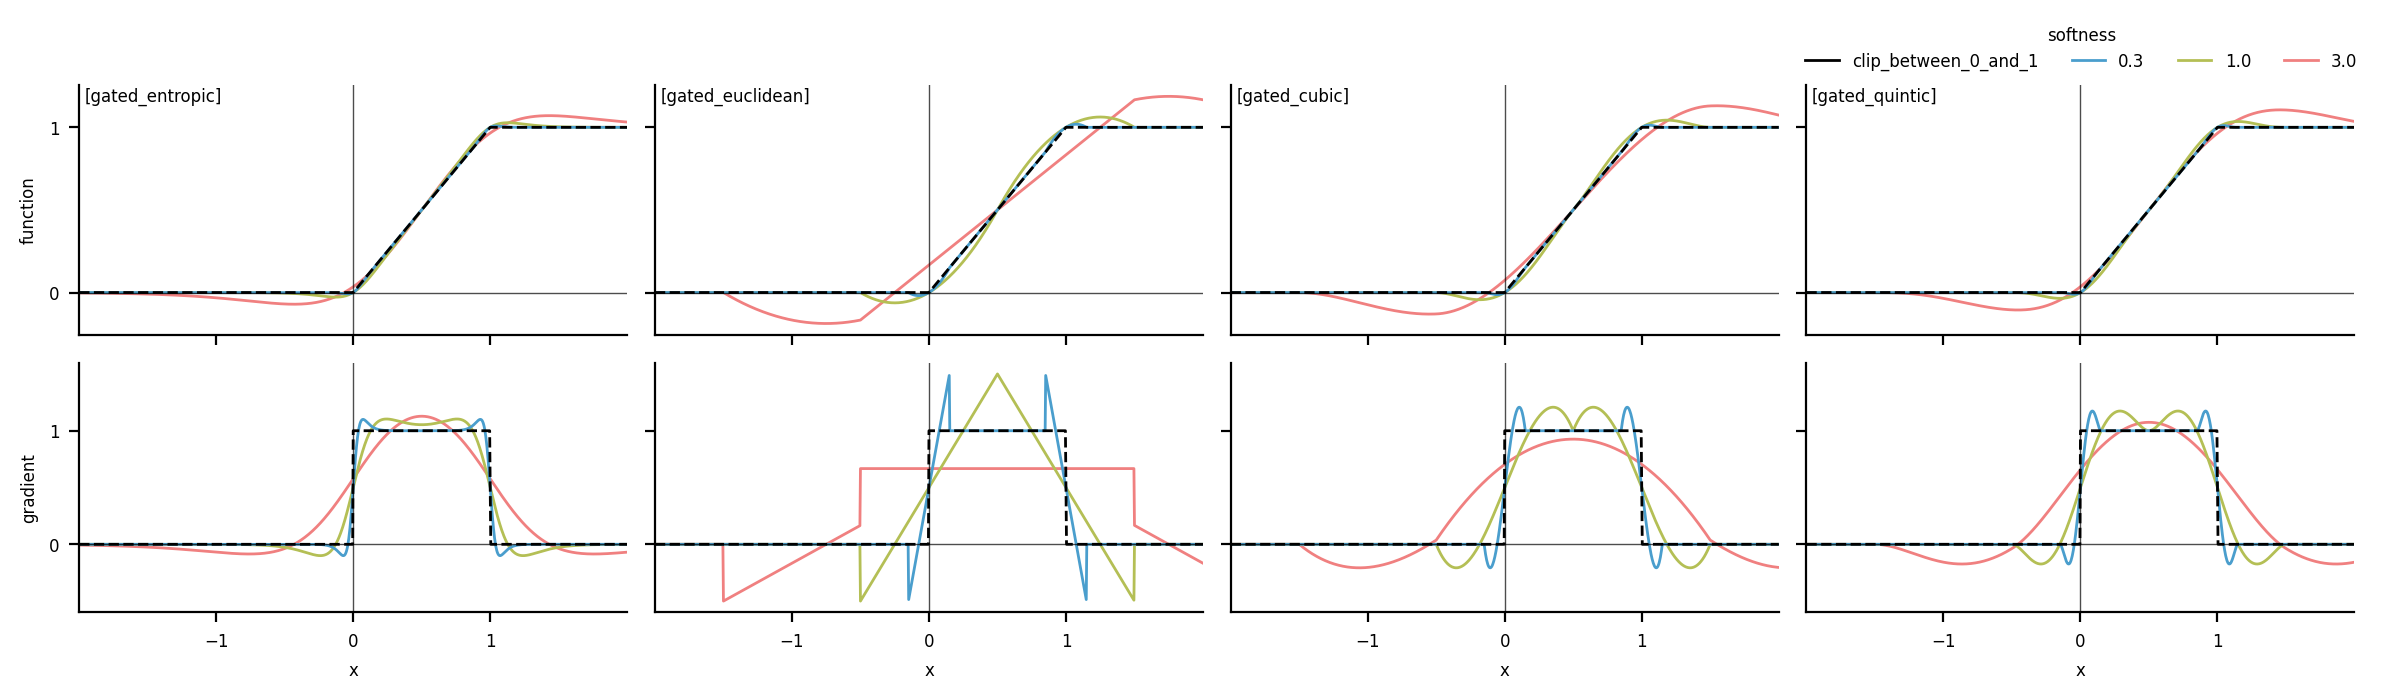

In [6]:
def clip_between_0_and_1(x, **kwargs):
    return sj.clip(x, jnp.array(0.0), jnp.array(1.0), **kwargs)


plot(sj.relu, modes=softplus_modes)
plot(sj.relu, modes=softplus_modes_gated)
plot(clip_between_0_and_1, modes=softplus_modes)
plot(clip_between_0_and_1, modes=softplus_modes_gated)

## Simplex-projection / optimal transport based

In [7]:
projection_modes = ["entropic", "euclidean"]

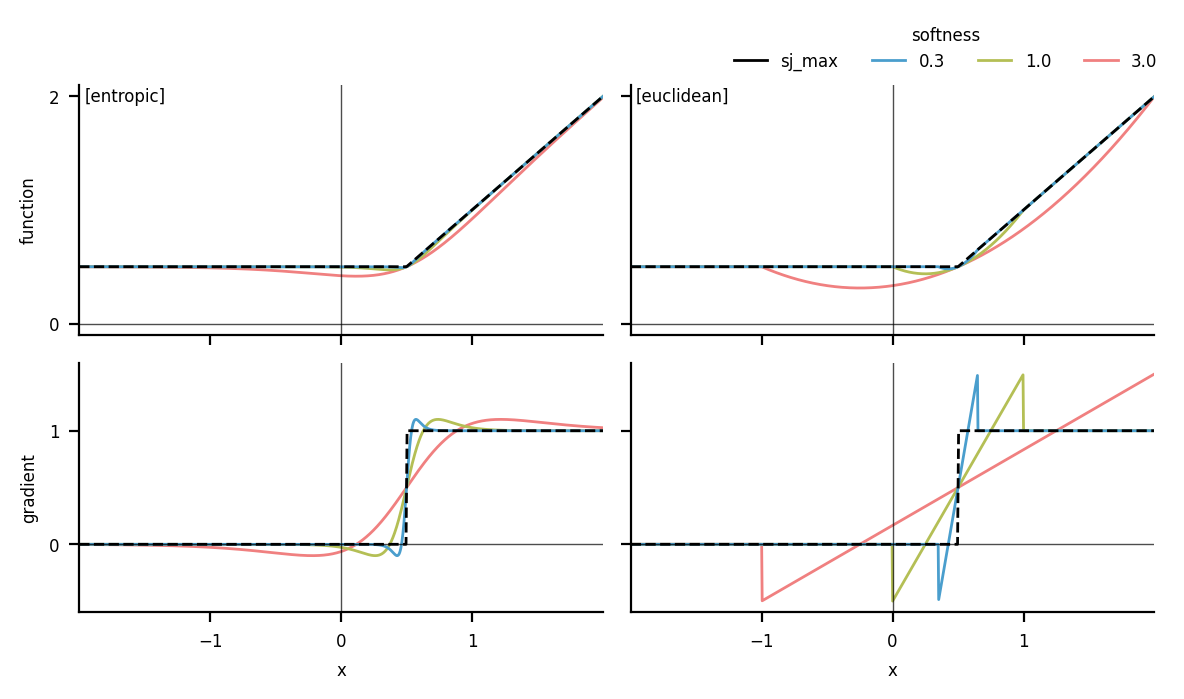

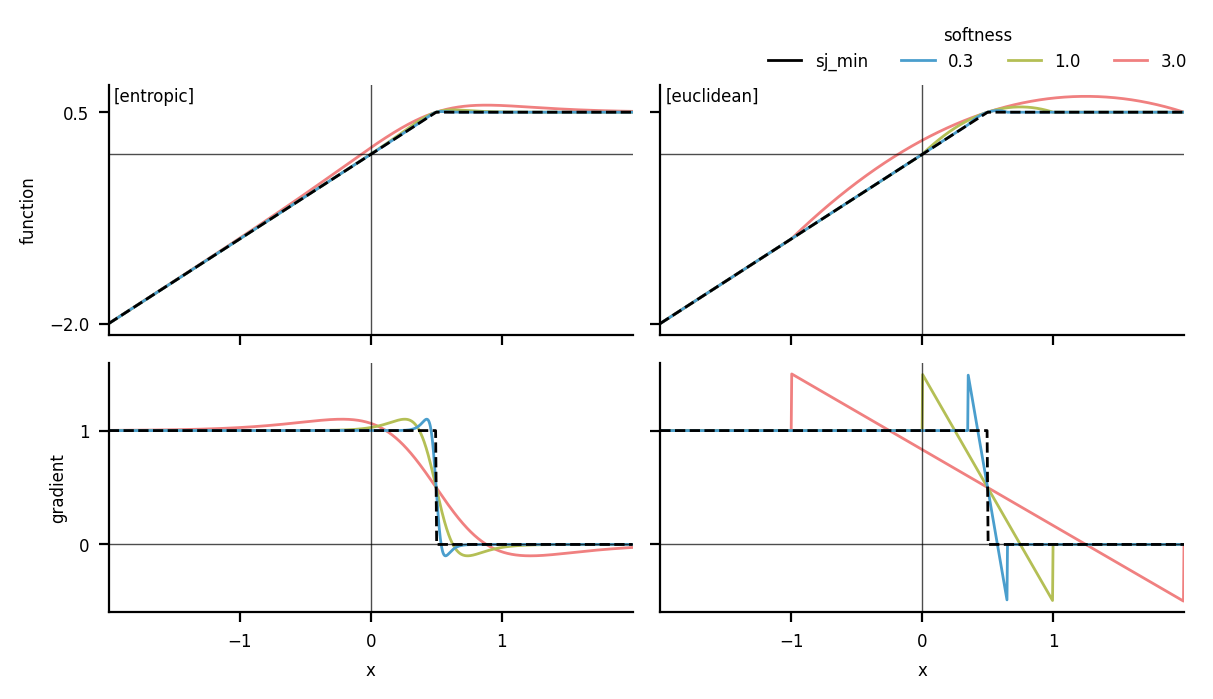

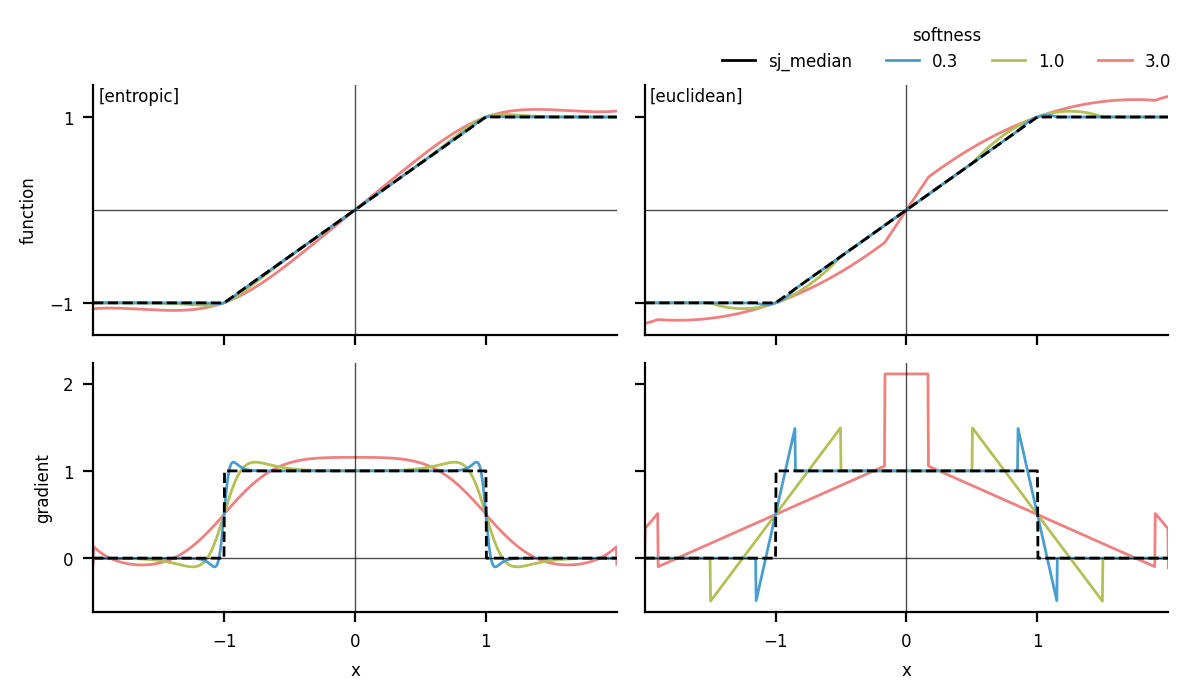

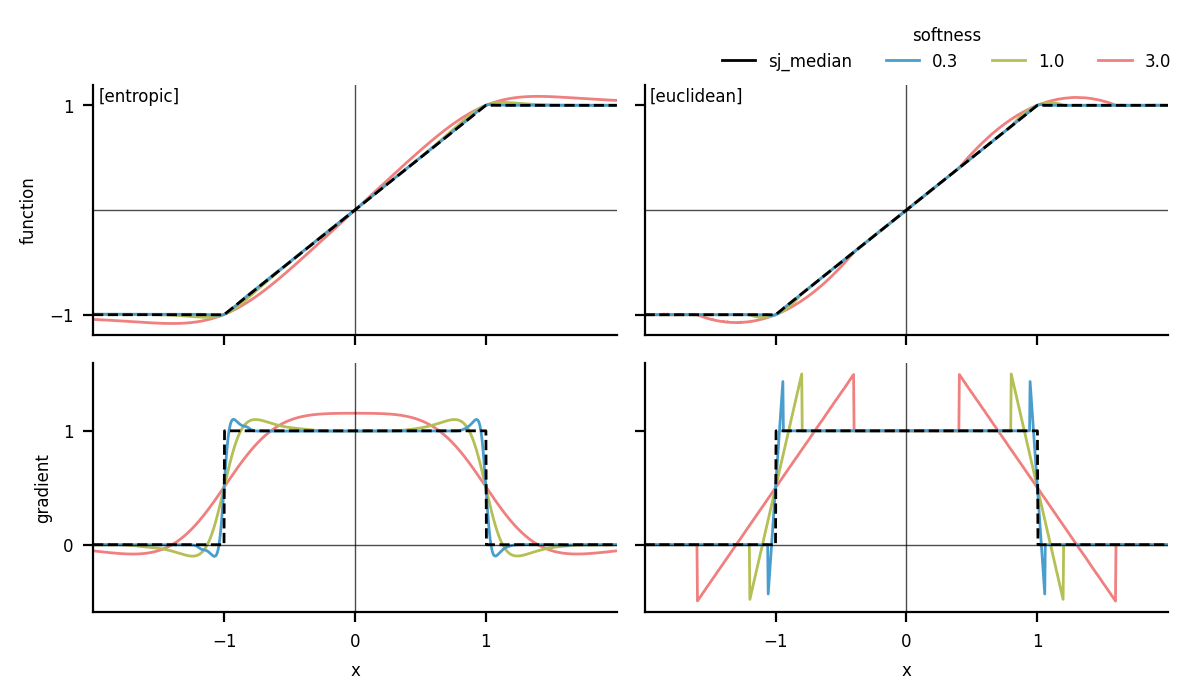

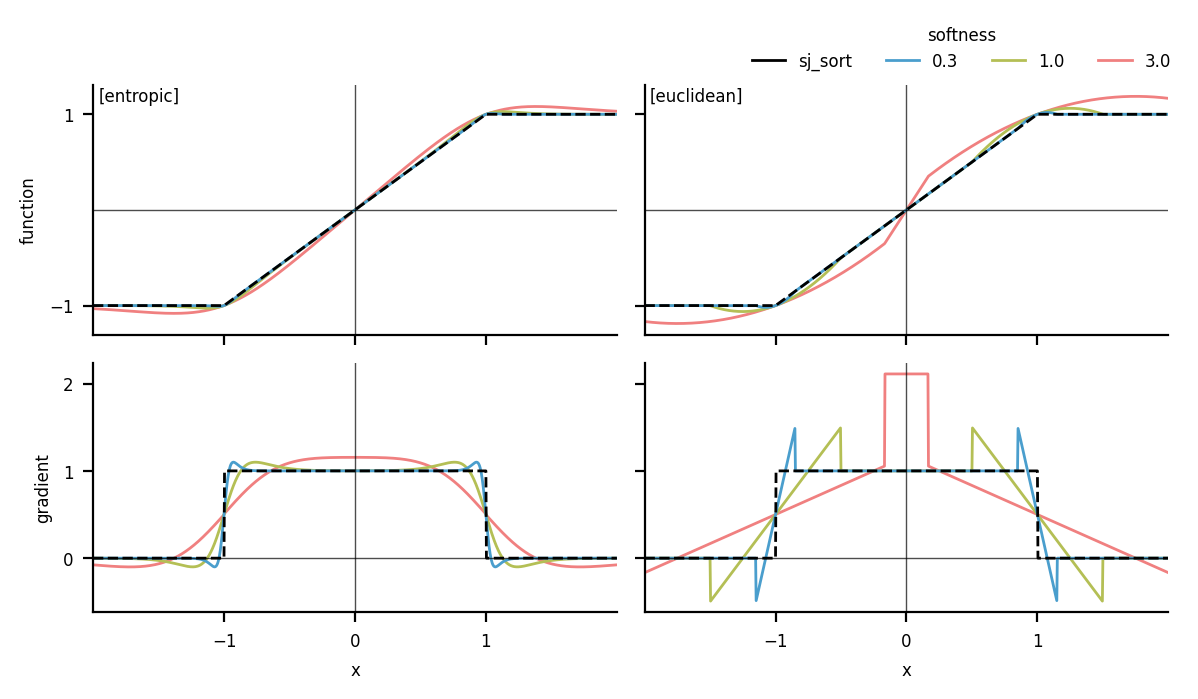

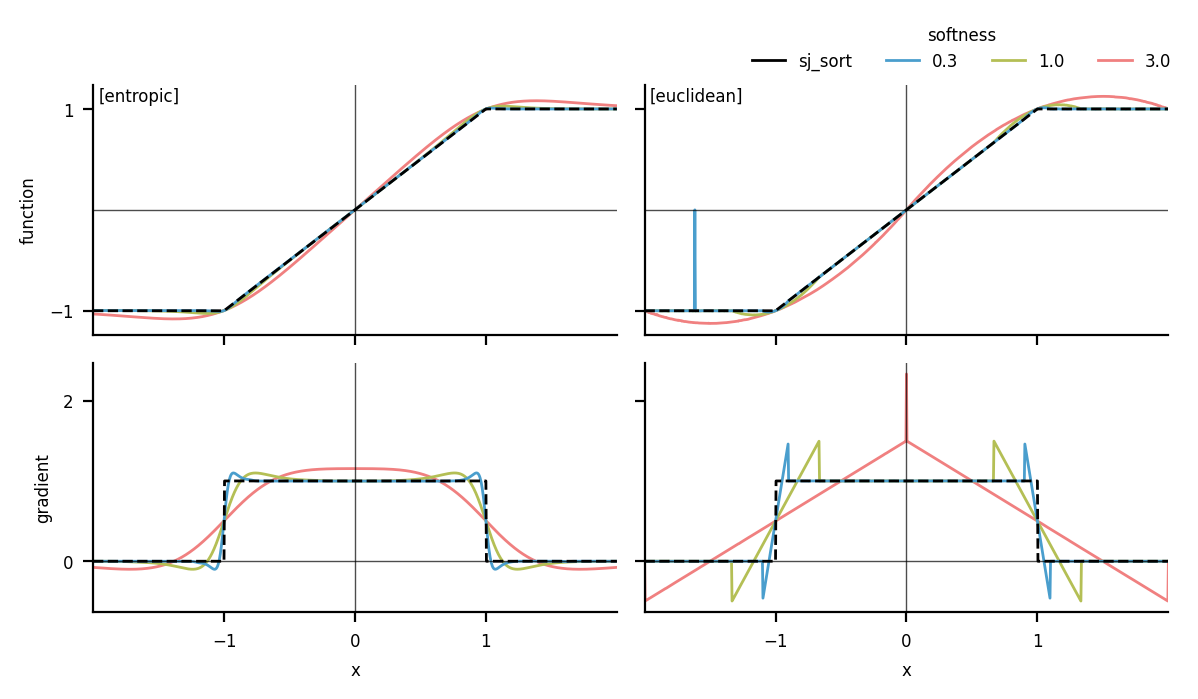

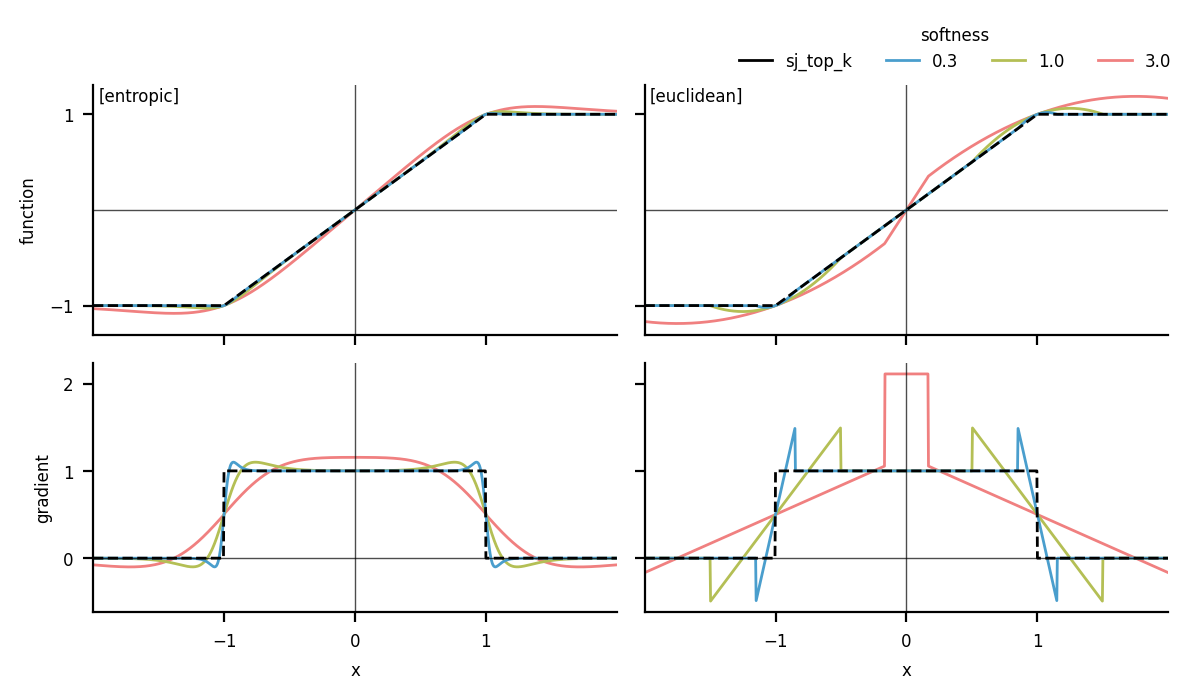

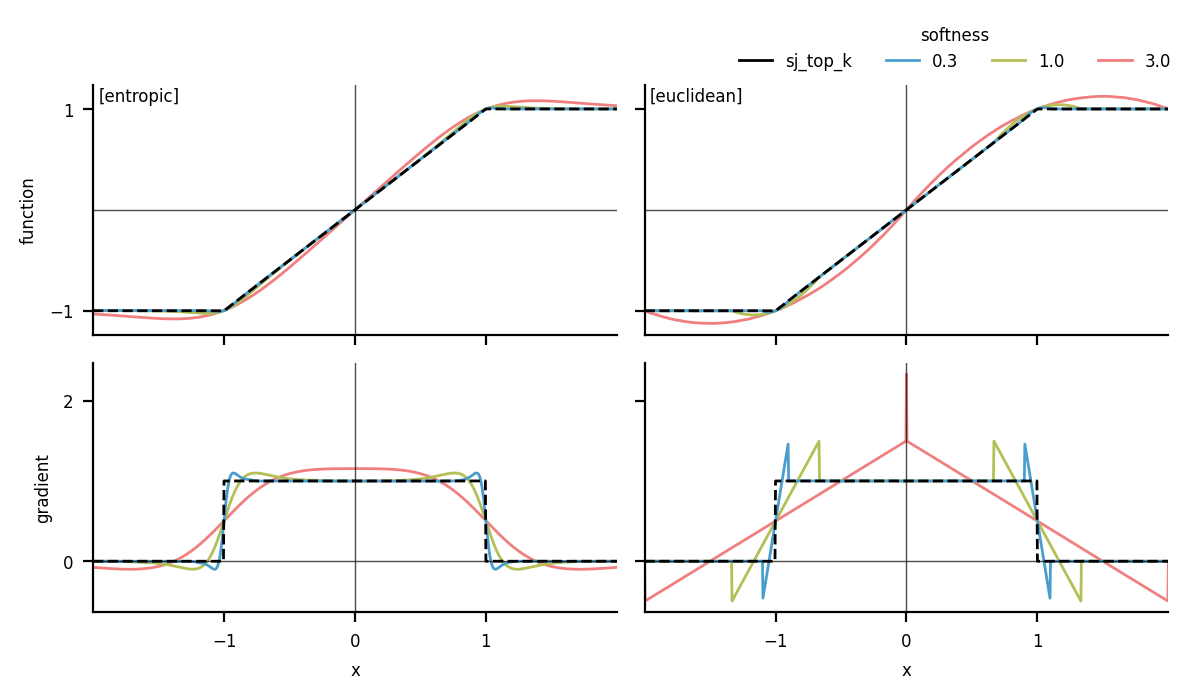

In [8]:
def sj_max(x, **kwargs):
    return sj.max(jnp.array([x, 0.5]), **kwargs)


def sj_min(x, **kwargs):
    return sj.min(jnp.array([x, 0.5]), **kwargs)


def sj_median(x, **kwargs):
    return sj.median(jnp.array([x, -1.0, 1.0, -2.0, 2.0]), **kwargs)


def sj_sort(x, **kwargs):
    return sj.sort(jnp.array([x, -1.0, 1.0]), **kwargs)[1]


def sj_top_k(x, **kwargs):
    return sj.top_k(jnp.array([x, -1.0, 1.0]), k=2, **kwargs)[0][1]


plot(sj_max, modes=projection_modes)
plot(sj_min, modes=projection_modes)
plot(sj_median, modes=projection_modes)
plot(sj_median, modes=projection_modes, fast=False)
plot(sj_sort, modes=projection_modes)
plot(sj_sort, modes=projection_modes, fast=False)
plot(sj_top_k, modes=projection_modes)
plot(sj_top_k, modes=projection_modes, fast=False)